# read SolO cdf data, convert and plot




In [1]:
#update heliosat

#!pip install heliosat==0.4.9
#install 0.5.0 from github

#spiceypy=3.0.2

In [74]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import  DateFormatter
from datetime import timedelta
from datetime import timezone
import pytz


import seaborn as sns
import datetime
import astropy
import astropy.constants as const
from sunpy.time import parse_time
import time
import pickle

import sys
import os
import urllib
import json
import importlib
import pandas as pd
import copy
import openpyxl
import h5py
import heliopy.data.spice as spicedata
import heliopy.spice as spice

import spiceypy

import heliosat


from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging

from heliocats import stats as hs
importlib.reload(hs) #reload again while debugging

#where the in situ data files are located is read 
#from config.py 
import config
importlib.reload(config)
from config import data_path
from config import data_path_ML


########### make directories first time if not there

resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

indexdir='icmecat/indices_icmecat' 
if os.path.isdir(indexdir) == False: os.mkdir(indexdir) 

catdir='icmecat'
if os.path.isdir(catdir) == False: os.mkdir(catdir)

icplotsdir='icmecat/plots_icmecat/' 
if os.path.isdir(icplotsdir) == False: os.mkdir(icplotsdir) 

plt.rcParams["figure.figsize"] = (15,5)


from astropy.constants import au
#define AU in km
AU=au.value/1e3
print('done')
print(heliosat.__version__)
print(spiceypy.__version__)

import cdflib

done
0.4.10
3.0.2


## read low latency data for quicklook

In [75]:
sns.set_style('whitegrid')
sns.set_context('paper')

#ll_path = "/nas/helio/data/SolarOrbiter/MAG/low_latency/"

ll_path = "/nas/helio/data/SolarOrbiter/MAG/low_lat_march22_new/"

ll_path = "/nas/helio/data/SolarOrbiter/MAG/low_lat_march22_march10big_real"



files = os.listdir(ll_path)
files.sort()
llfiles = [os.path.join(ll_path, f) for f in files]
#print(llfiles)


br1=np.zeros(0)
bt1=np.zeros(0)
bn1=np.zeros(0)
time1=np.zeros(0,dtype=[('time',object)])


for i in np.arange(0,len(llfiles)):
    m1 = cdflib.CDF(llfiles[i])
    #print(m1.cdf_info())


    b=m1.varget('B_RTN')
    br=b[:,0]
    bt=b[:,1]
    bn=b[:,2]
    
    br1=np.append(br1,br)
    bt1=np.append(bt1,bt)
    bn1=np.append(bn1,bn)

    time=m1.varget('EPOCH')

    t1=parse_time(cdflib.cdfastropy.convert_to_astropy(time, format=None)).datetime
    time1=np.append(time1,t1)
    

solo_ll=np.zeros(np.size(time1),dtype=[('time',object),('bx', float),('by', float),\
            ('bz', float),('bt', float),('r', float),('lat', float),('lon', float),('x', float),('y', float),('z', float)])   
solo_ll = solo_ll.view(np.recarray)  

solo_ll.time=time1
solo_ll.bx=br1
solo_ll.by=bt1
solo_ll.bz=bn1
solo_ll.bt=np.sqrt(br1**2+bt1**2+bn1**2)

solo_pos=heliosat.SOLO().trajectory(solo_ll.time, frame="HEEQ")
solo_ll.x=solo_pos[:,0]
solo_ll.y=solo_pos[:,1]
solo_ll.z=solo_pos[:,2]
[solo_ll.r, solo_ll.lat, solo_ll.lon]=hd.cart2sphere(solo_pos[:,0],solo_pos[:,1],solo_pos[:,2])
solo_ll.lon=np.rad2deg(solo_ll.lon) #convert to degree
solo_ll.lat=np.rad2deg(solo_ll.lat)


filename='solo_2022_march_lowlat_march10.p'
pickle.dump(solo_ll, open(data_path+filename, "wb"))
 

In [76]:
print('load Solar Orbiter lowlat RTN ')
filename='solo_2022_march_lowlat_march10.p'
solo_ll=pickle.load(open(data_path+filename, "rb" ) )  

load Solar Orbiter lowlat RTN 


2022-03-12 16:30:23.730002
2022-03-12 18:14:12.835945

1.73 hours

0.42975682004578597 AU
11.918652869927872 long


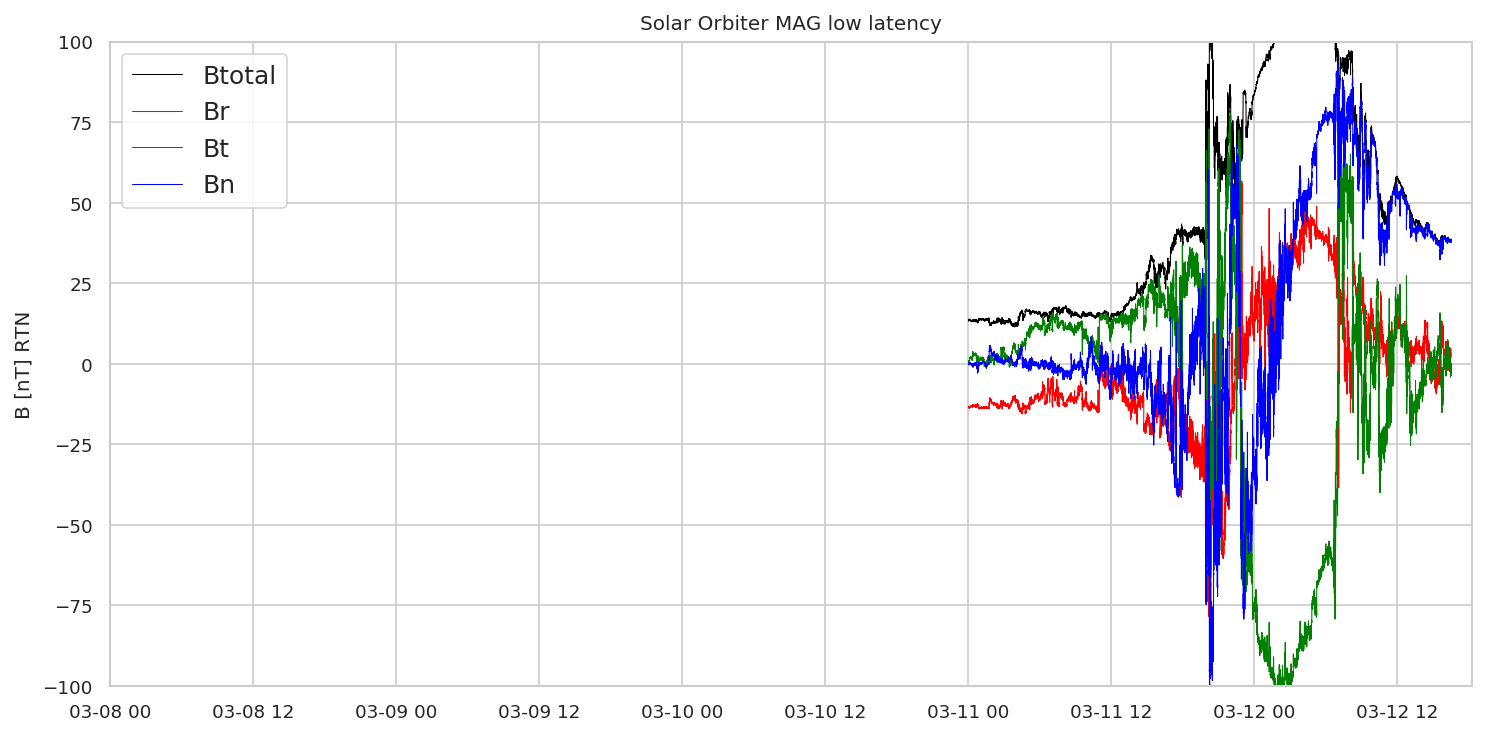

In [77]:
plt.figure(1,figsize=(10,5),dpi=150)

plt.plot(solo_ll.time,solo_ll.bt,color='black',lw=0.5, label='Btotal')
plt.plot(solo_ll.time,solo_ll.bx, color='r',lw=0.5,label='Br')
plt.plot(solo_ll.time,solo_ll.by,color='g',lw=0.5,label='Bt')
plt.plot(solo_ll.time,solo_ll.bz,color='b',lw=0.5,label='Bn')

plt.ylim(-100,100)
    
plotstart=datetime.datetime(2022,3,8,0)
plotend=datetime.datetime.utcnow()
plt.xlim(plotstart,plotend)
plt.legend(loc=2,fontsize=12)
plt.ylabel('B [nT] RTN')
plt.title('Solar Orbiter MAG low latency')

plt.tight_layout()

plt.savefig('lineups/solo_2022_lowlat_march10.png')
plt.savefig('lineups/solo_2022_lowlat_march10.pdf')

tsolo=solo_ll.time[-1]
tsolo_md=mdates.date2num(tsolo)

tnow=datetime.datetime.utcnow()
tnow_md=mdates.date2num(tnow) 
lag=tnow_md-tsolo_md   #lag in days
lag_h=np.round(lag*24,2)   #lag in hours




print(tsolo)
print(tnow)
print()
print(lag_h,'hours')
print()

print(solo_ll.r[-1], 'AU')
print(solo_ll.lon[-1], 'long')

### NOAA Real time DSCOVR and other data

In [78]:

#predstorm real time forecast
filename='/nas/helio/realcode/real/predstorm/predstorm_real_1m.txt'

noaa_raw=np.loadtxt(filename)


noaa_real=np.zeros(len(noaa_raw[:,1]),dtype=[('time',object),('bx', float),('by', float),\
                    ('bz', float),('bt', float),('np', float),('vt', float),('vx', float),\
                          ('vy', float),('vz', float),\
                          ('tp', float),('x', float),('y', float),('z', float),\
                    ('r', float),('lat', float),('lon', float)])   

#convert to recarray
noaa_real = noaa_real.view(np.recarray)  

noaa_real.time=mdates.num2date(noaa_raw[:,6])

noaa_real.bt=noaa_raw[:,7]
noaa_real.bx=noaa_raw[:,8]
noaa_real.by=noaa_raw[:,9]
noaa_real.bz=noaa_raw[:,10]
noaa_real.vt=noaa_raw[:,12]

#cut of recurrence prediction
cut=np.where(mdates.date2num(noaa_real.time) > mdates.date2num(datetime.datetime.utcnow()-timedelta(hours=1)))
noaa_real.bt[cut]=np.nan
noaa_real.bx[cut]=np.nan
noaa_real.by[cut]=np.nan
noaa_real.bz[cut]=np.nan
noaa_real.vt[cut]=np.nan

In [79]:
print('load data RTN') 

#filepsp='psp_2018_2021_rtn.p'
#[psp,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) ) 

#final data files, stops day before
#filenoaa="noaa_rtsw_last100days_now.p" 
#[noaa,hnoaa]=pickle.load(open(data_path+filenoaa, "rb" ) )  


#wind
filewin="wind_2018_now_heeq.p" 
[win,hwin]=pickle.load(open(data_path+filewin, "rb" ) )  

filesta='stereoa_2020_now_rtn_beacon.p'
[sta,hsta]=pickle.load(open(data_path+filesta, "rb" ) )  

filebepi='bepi_2021_aug_2021_nov_rtn.p'
bepi=pickle.load(open(data_path+filebepi, "rb" ) ) 

filesolo='solo_2021_2022_lowlat.p'
solo=pickle.load(open(data_path+filesolo, "rb" ) ) 

print('done')
    

load data RTN
done


## Event SolO 2022 March 10

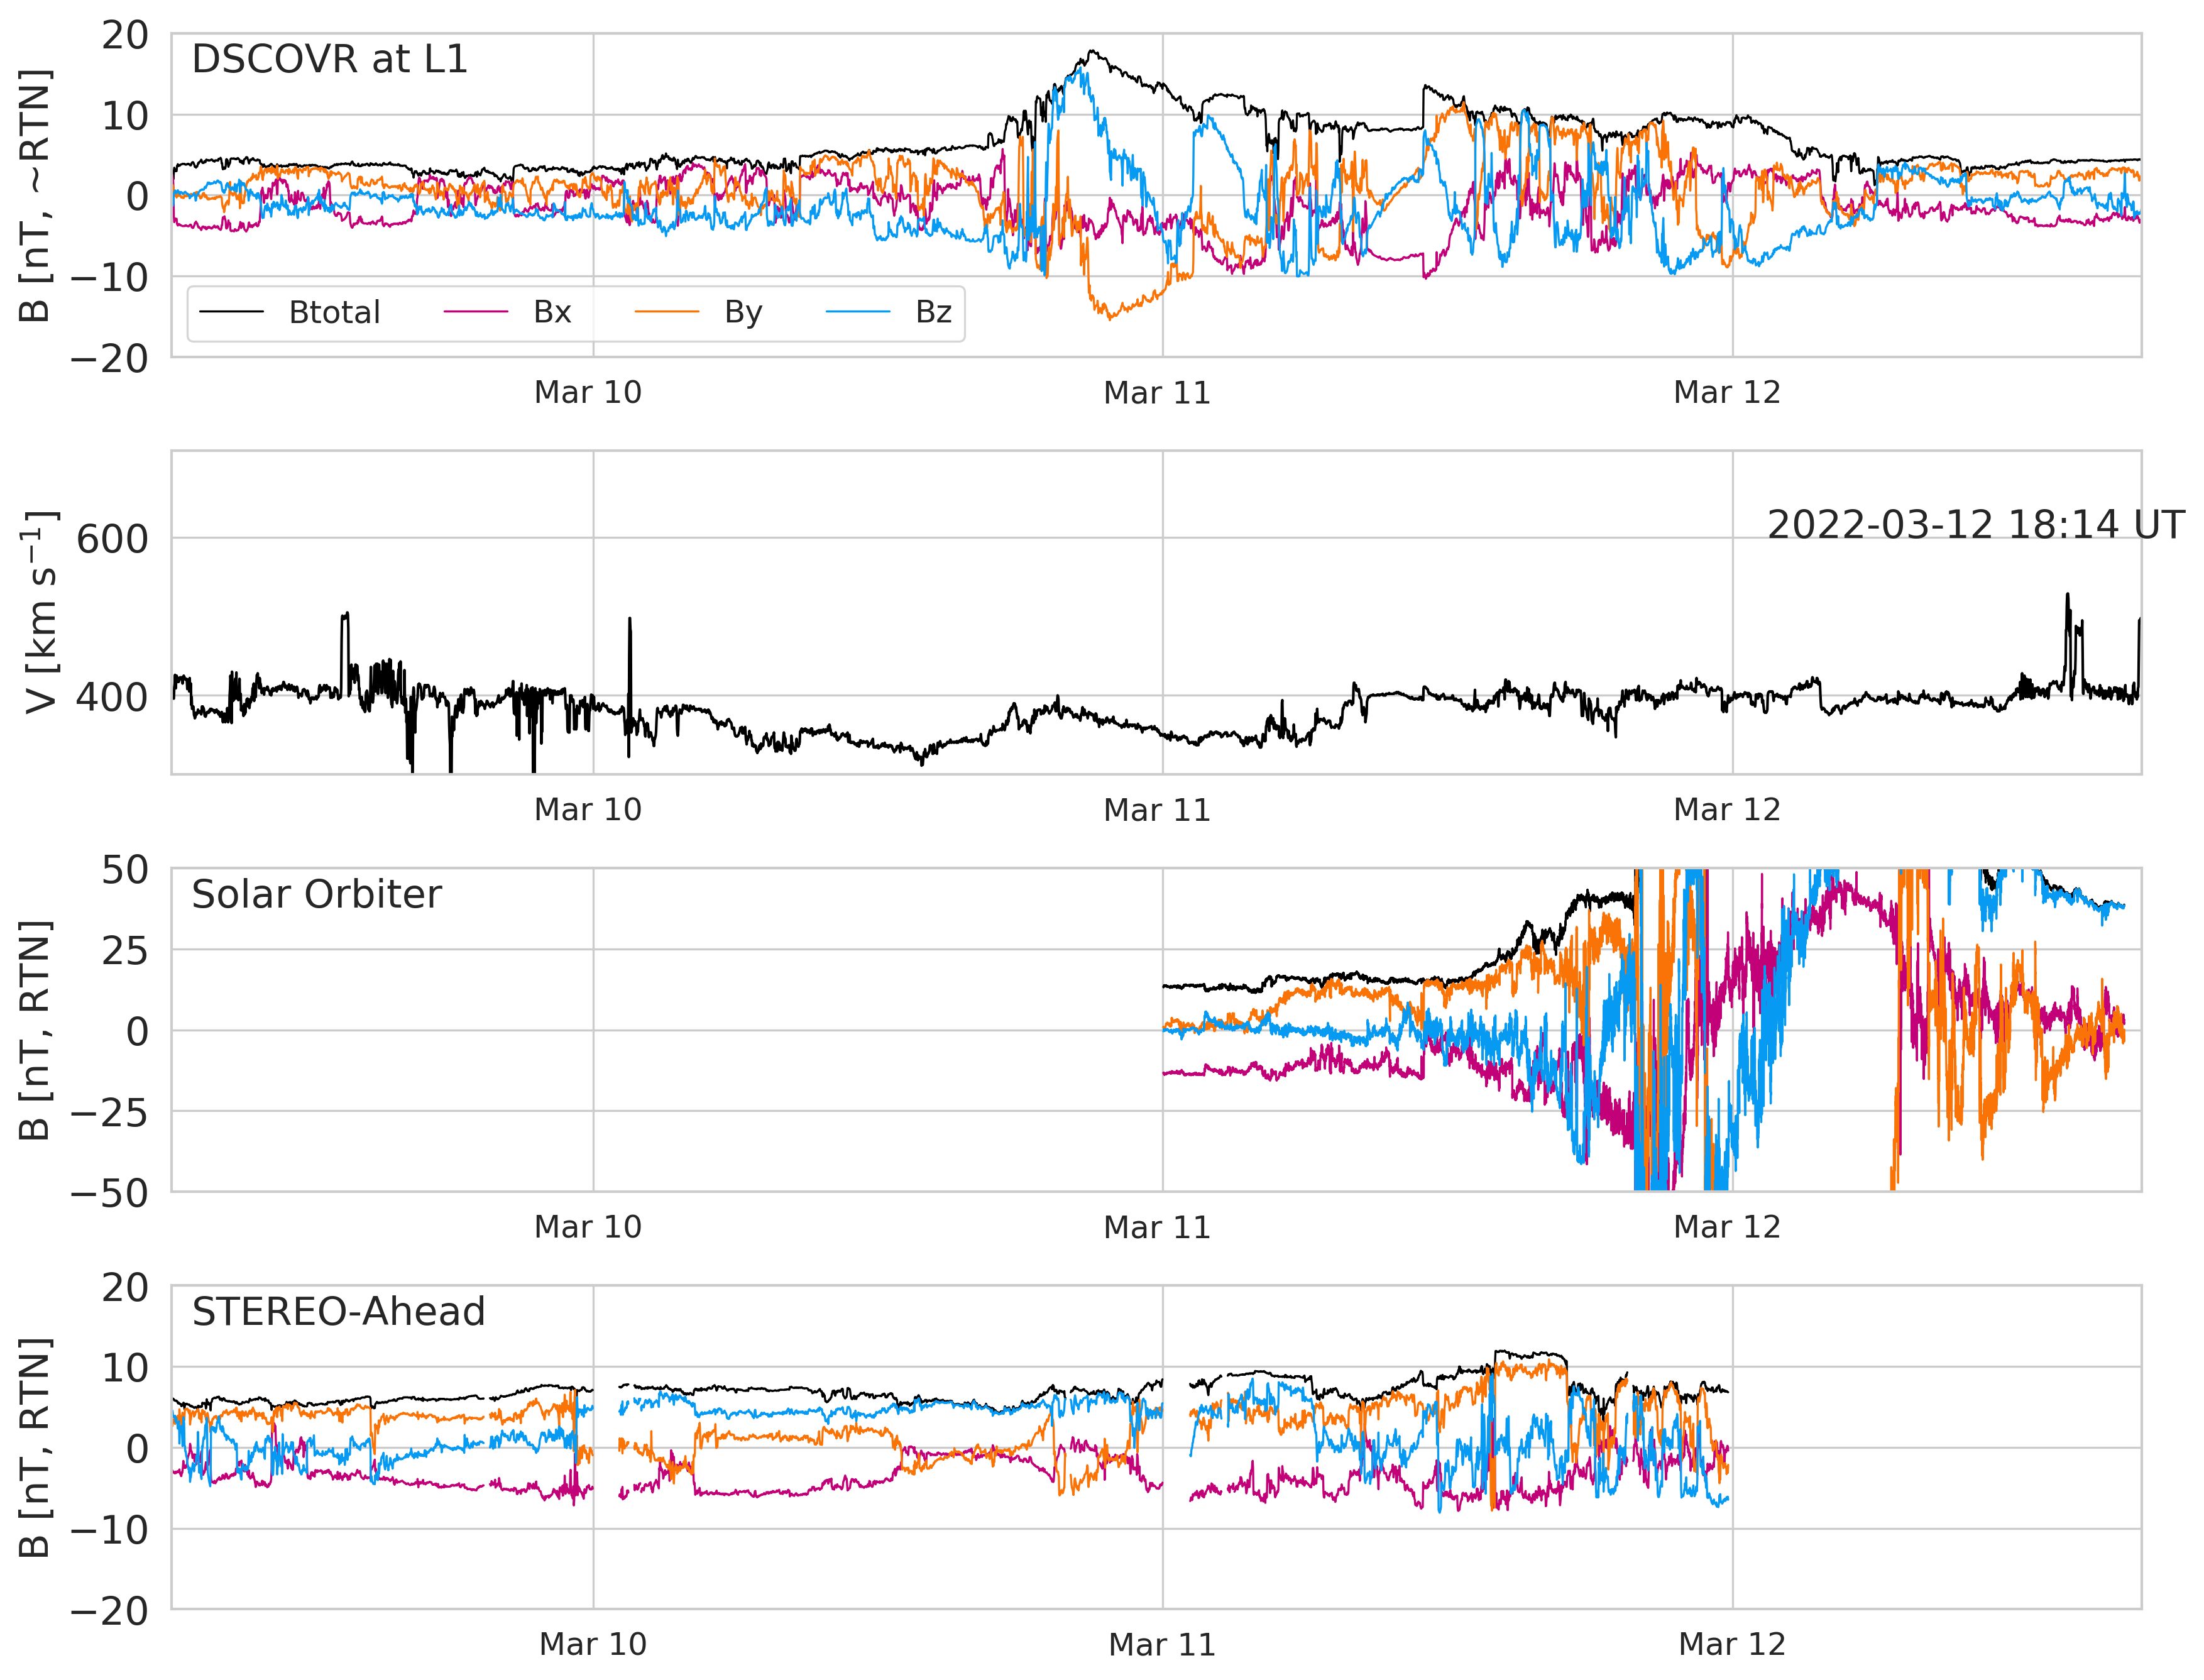

In [80]:
sns.set_style('whitegrid')
sns.set_context('paper')

plt.figure(1,figsize=(12, 9),dpi=300)

#define subplot grid
ax1 = plt.subplot2grid((4, 1), (0, 0))  
ax2 = plt.subplot2grid((4, 1), (3, 0))  
ax3 = plt.subplot2grid((4, 1), (2, 0))  
ax11 = plt.subplot2grid((4, 1), (1, 0))  
#ax4 = plt.subplot2grid((5, 1), (4, 0))  




#plotstart=datetime.datetime(2021,10,11)
#plotend=datetime.datetime(2021,10,13,6)

#plotstart=datetime.datetime(2022,1,30)
#plotend=datetime.datetime(2022,2,5)
plotstart=datetime.datetime.utcnow()-timedelta(days=3.5)
plotend=datetime.datetime.utcnow()-timedelta(hours=1)

blim=20

linewi=0.8

days_dist=1


#NOAA real time in approx RTN
ax1.plot(noaa_real.time, noaa_real.bt, "k-", lw=linewi,label='Btotal')
ax1.plot(noaa_real.time, -noaa_real.bx, "r-", color="xkcd:magenta", lw=linewi, label='Bx')
ax1.plot(noaa_real.time, -noaa_real.by, "g-", color="xkcd:orange", lw=linewi,label='By')
ax1.plot(noaa_real.time, noaa_real.bz, "b-", color="xkcd:azure", lw=linewi,label='Bz')


#ax1.plot(win.time, win.bt, "k-", lw=linewi,label='Btotal')
#ax1.plot(win.time, win.bx, "r-", color="xkcd:magenta", lw=linewi, label='Bx')
#ax1.plot(win.time, win.by, "g-", color="xkcd:orange", lw=linewi,label='By')
#ax1.plot(win.time, win.bz, "b-", color="xkcd:azure", lw=linewi,label='Bz')

ax1.set_ylabel('B [nT, ~RTN]',fontsize=15)
ax1.set_xlim(plotstart,plotend)
ax1.set_ylim(-blim,blim)
ax1.legend(loc=3,ncol=4,fontsize=12)
ax1.grid(True)
ax1.tick_params(axis='y', labelsize=15)
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d ') )
ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))
ax1.tick_params(axis='x', labelsize=12)
#ax1.set_xticklabels([])


ax11.plot(noaa_real.time, noaa_real.vt, color="black",linewidth=1,label='Vp Wind')
#ax11.plot(win.time, win.vt, color="black",linewidth=1,label='Vp Wind')


ax11.set_ylabel('V [km $\mathrm{s^{-1}}$]',fontsize=15)
ax11.set_xlim(plotstart,plotend)
ax11.set_ylim(300,710)
ax11.tick_params(axis='y', labelsize=15)
ax11.grid(True)
ax11.tick_params(axis='x', labelsize=12)
ax11.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d ') )
ax11.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))

#ax11.set_xticklabels([])




### STEREO-A
blim=20

ax2.plot(sta.time, sta.bt, "k-", lw=linewi,label='Btotal')
ax2.plot(sta.time, sta.bx, "r-", color="xkcd:magenta", lw=linewi, label='Br')
ax2.plot(sta.time, sta.by, "g-", color="xkcd:orange", lw=linewi,label='Bt')
ax2.plot(sta.time, sta.bz, "b-", color="xkcd:azure", lw=linewi,label='Bn')
    
ax2.set_ylabel('B [nT, RTN]',fontsize=15)
ax2.set_xlim(plotstart,plotend)
ax2.set_ylim(-blim,blim)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=15)
#ax2.legend(loc=1,ncol=4,fontsize=15)
ax2.grid(True)
ax2.set_xticklabels([])
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d') )
ax2.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))


### Solar Orbiter
blim=50
ax3.plot(solo.time, solo.bt, "k-", lw=linewi,label='Btotal')
ax3.plot(solo.time, solo.bx, "r-", color="xkcd:magenta", lw=linewi, label='Bx')
ax3.plot(solo.time, solo.by, "g-", color="xkcd:orange", lw=linewi,label='By')
ax3.plot(solo.time, solo.bz, "b-", color="xkcd:azure", lw=linewi,label='Bz')

ax3.plot(solo_ll.time, solo_ll.bt, "k-", lw=linewi,label='Btotal')
ax3.plot(solo_ll.time, solo_ll.bx, "r-", color="xkcd:magenta", lw=linewi, label='Bx')
ax3.plot(solo_ll.time, solo_ll.by, "g-", color="xkcd:orange", lw=linewi,label='By')
ax3.plot(solo_ll.time, solo_ll.bz, "b-", color="xkcd:azure", lw=linewi,label='Bz')


    
ax3.set_ylabel('B [nT, RTN]',fontsize=15)
ax3.set_xlim(plotstart,plotend)
ax3.set_ylim(-blim,blim)
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', labelsize=15)
#ax2.legend(loc=1,ncol=4,fontsize=15)
ax3.grid(True)
ax3.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d ') )
ax3.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))


### Bepi
blim=80

#ax4.plot(bepi.time, bepi.bt, "k-", lw=linewi,label='Btotal')
#ax4.plot(bepi.time, bepi.bx, "r-", color="xkcd:magenta", lw=linewi, label='Br')
#ax4.plot(bepi.time, bepi.by, "g-", color="xkcd:orange", lw=linewi,label='Bt')
#ax4.plot(bepi.time, bepi.bz, "b-", color="xkcd:azure", lw=linewi,label='Bn')


######################################## longitudes


#ax4.plot(sta.time, sta.lon, linestyle="-", color="red", lw=linewi,label='STEREO-A')
#ax4.plot(solo.time, solo.lon, linestyle="-", color="orange", lw=linewi,label='SolO')
#ax4.plot(solo.time, np.zeros(len(solo.time)), "b-", color="xkcd:azure", lw=linewi,label='Earth')


#ax4.set_ylabel(' long. [deg]',fontsize=15)
#ax4.set_xlim(plotstart,plotend)
#ax4.set_ylim(-7,7)
#ax4.tick_params(axis='x', labelsize=12)
#ax4.tick_params(axis='y', labelsize=15)
#ax4.grid(True)
#ax4.legend(loc=2)
#ax4.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d ') )
#ax4.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))


ax1.annotate('DSCOVR at L1',(0.01,0.88),xycoords='axes fraction',fontsize=15,bbox=dict(facecolor='white', edgecolor='None', pad=2.0))
ax2.annotate('STEREO-Ahead',(0.01,0.88),xycoords='axes fraction',fontsize=15,bbox=dict(facecolor='white', edgecolor='None', pad=2.0))
ax3.annotate('Solar Orbiter',(0.01,0.88),xycoords='axes fraction',fontsize=15,bbox=dict(facecolor='white', edgecolor='None', pad=2.0))
#ax4.annotate('BepiColombo',(0.01,0.88),xycoords='axes fraction',fontsize=15,bbox=dict(facecolor='white', edgecolor='None', pad=2.0))

#ax2.annotate('Data sources: Solar Orbiter MAG (Imperial College), DSCOVR (NOAA), STEREO-A (UCLA, NASA)',(0.01,0.02),xycoords='axes fraction',fontsize=10)
#ax4.annotate('Data source: BepiColombo MPO-MAG (IGEP Braunschweig/IWF Graz/ISAS/IC)',(0.01,0.02),xycoords='axes fraction',fontsize=10)




tnow_str=str(datetime.datetime.utcnow())[0:16]

ax11.text(datetime.datetime.utcnow()-timedelta(days=0.7), 600, tnow_str+' UT', fontsize=15)


plt.tight_layout()


plt.savefig('lineups/figure_2022_march10.png')
plt.savefig('lineups/figure_2022_march10.pdf')
#plt.savefig('lineups/fall_2021/figure_2021_fall_lineups_beg_oct1.pdf')
#plt.savefig('lineups/figure_2020_sep_lineups.pdf')

#ax2.plot(bepi.time, bepi.bt, "k-", lw=1,label='Btotal')
#ax2.plot(bepi.time, bepi.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
#ax2.plot(bepi.time, bepi.by, "g-", color="xkcd:orange", lw=1,label='Bt')
#ax2.plot(bepi.time, bepi.bz, "b-", color="xkcd:azure", lw=1,label='Bn')

#ax3.plot(win.time, win.bt, "k-", lw=1,label='Btotal')
#ax3.plot(win.time, win.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
#ax3.plot(win.time, win.by, "g-", color="xkcd:orange", lw=1,label='Bt')
#ax3.plot(win.time, win.bz, "b-", color="xkcd:azure", lw=1,label='Bn')

## Calculate Solo prediction

In [83]:

solop=copy.deepcopy(solo_ll)



#time delay
rs=solo.r[-1]
re=0.992854 

print(re-rs)


vcme=550*1e3 #m/s

print('constant speed ',vcme,' km/s from Solo to Earth')



t_delay=(re-rs)*au.value/vcme /3600  #m, m/s, convert seconds to hours
print(t_delay)

solop.time=solop.time+timedelta(hours=t_delay)

re=0.992854 
solop.bt=solop.bt*(re/solop.r[1])**(-1.64)
solop.bx=solop.bx*(re/solop.r[1])**(-1.64)
solop.by=solop.by*(re/solop.r[1])**(-1.64)
solop.bz=solop.bz*(re/solop.r[1])**(-1.64)

0.5131711960600299
constant speed  550000.0  km/s from Solo to Earth
38.77238294704682


maximum Bt at SolO  109.90104866782735
maximum Bt at Earth predicted 30.094467974893195
minimum Bz at Earth predicted 25.646748780089112


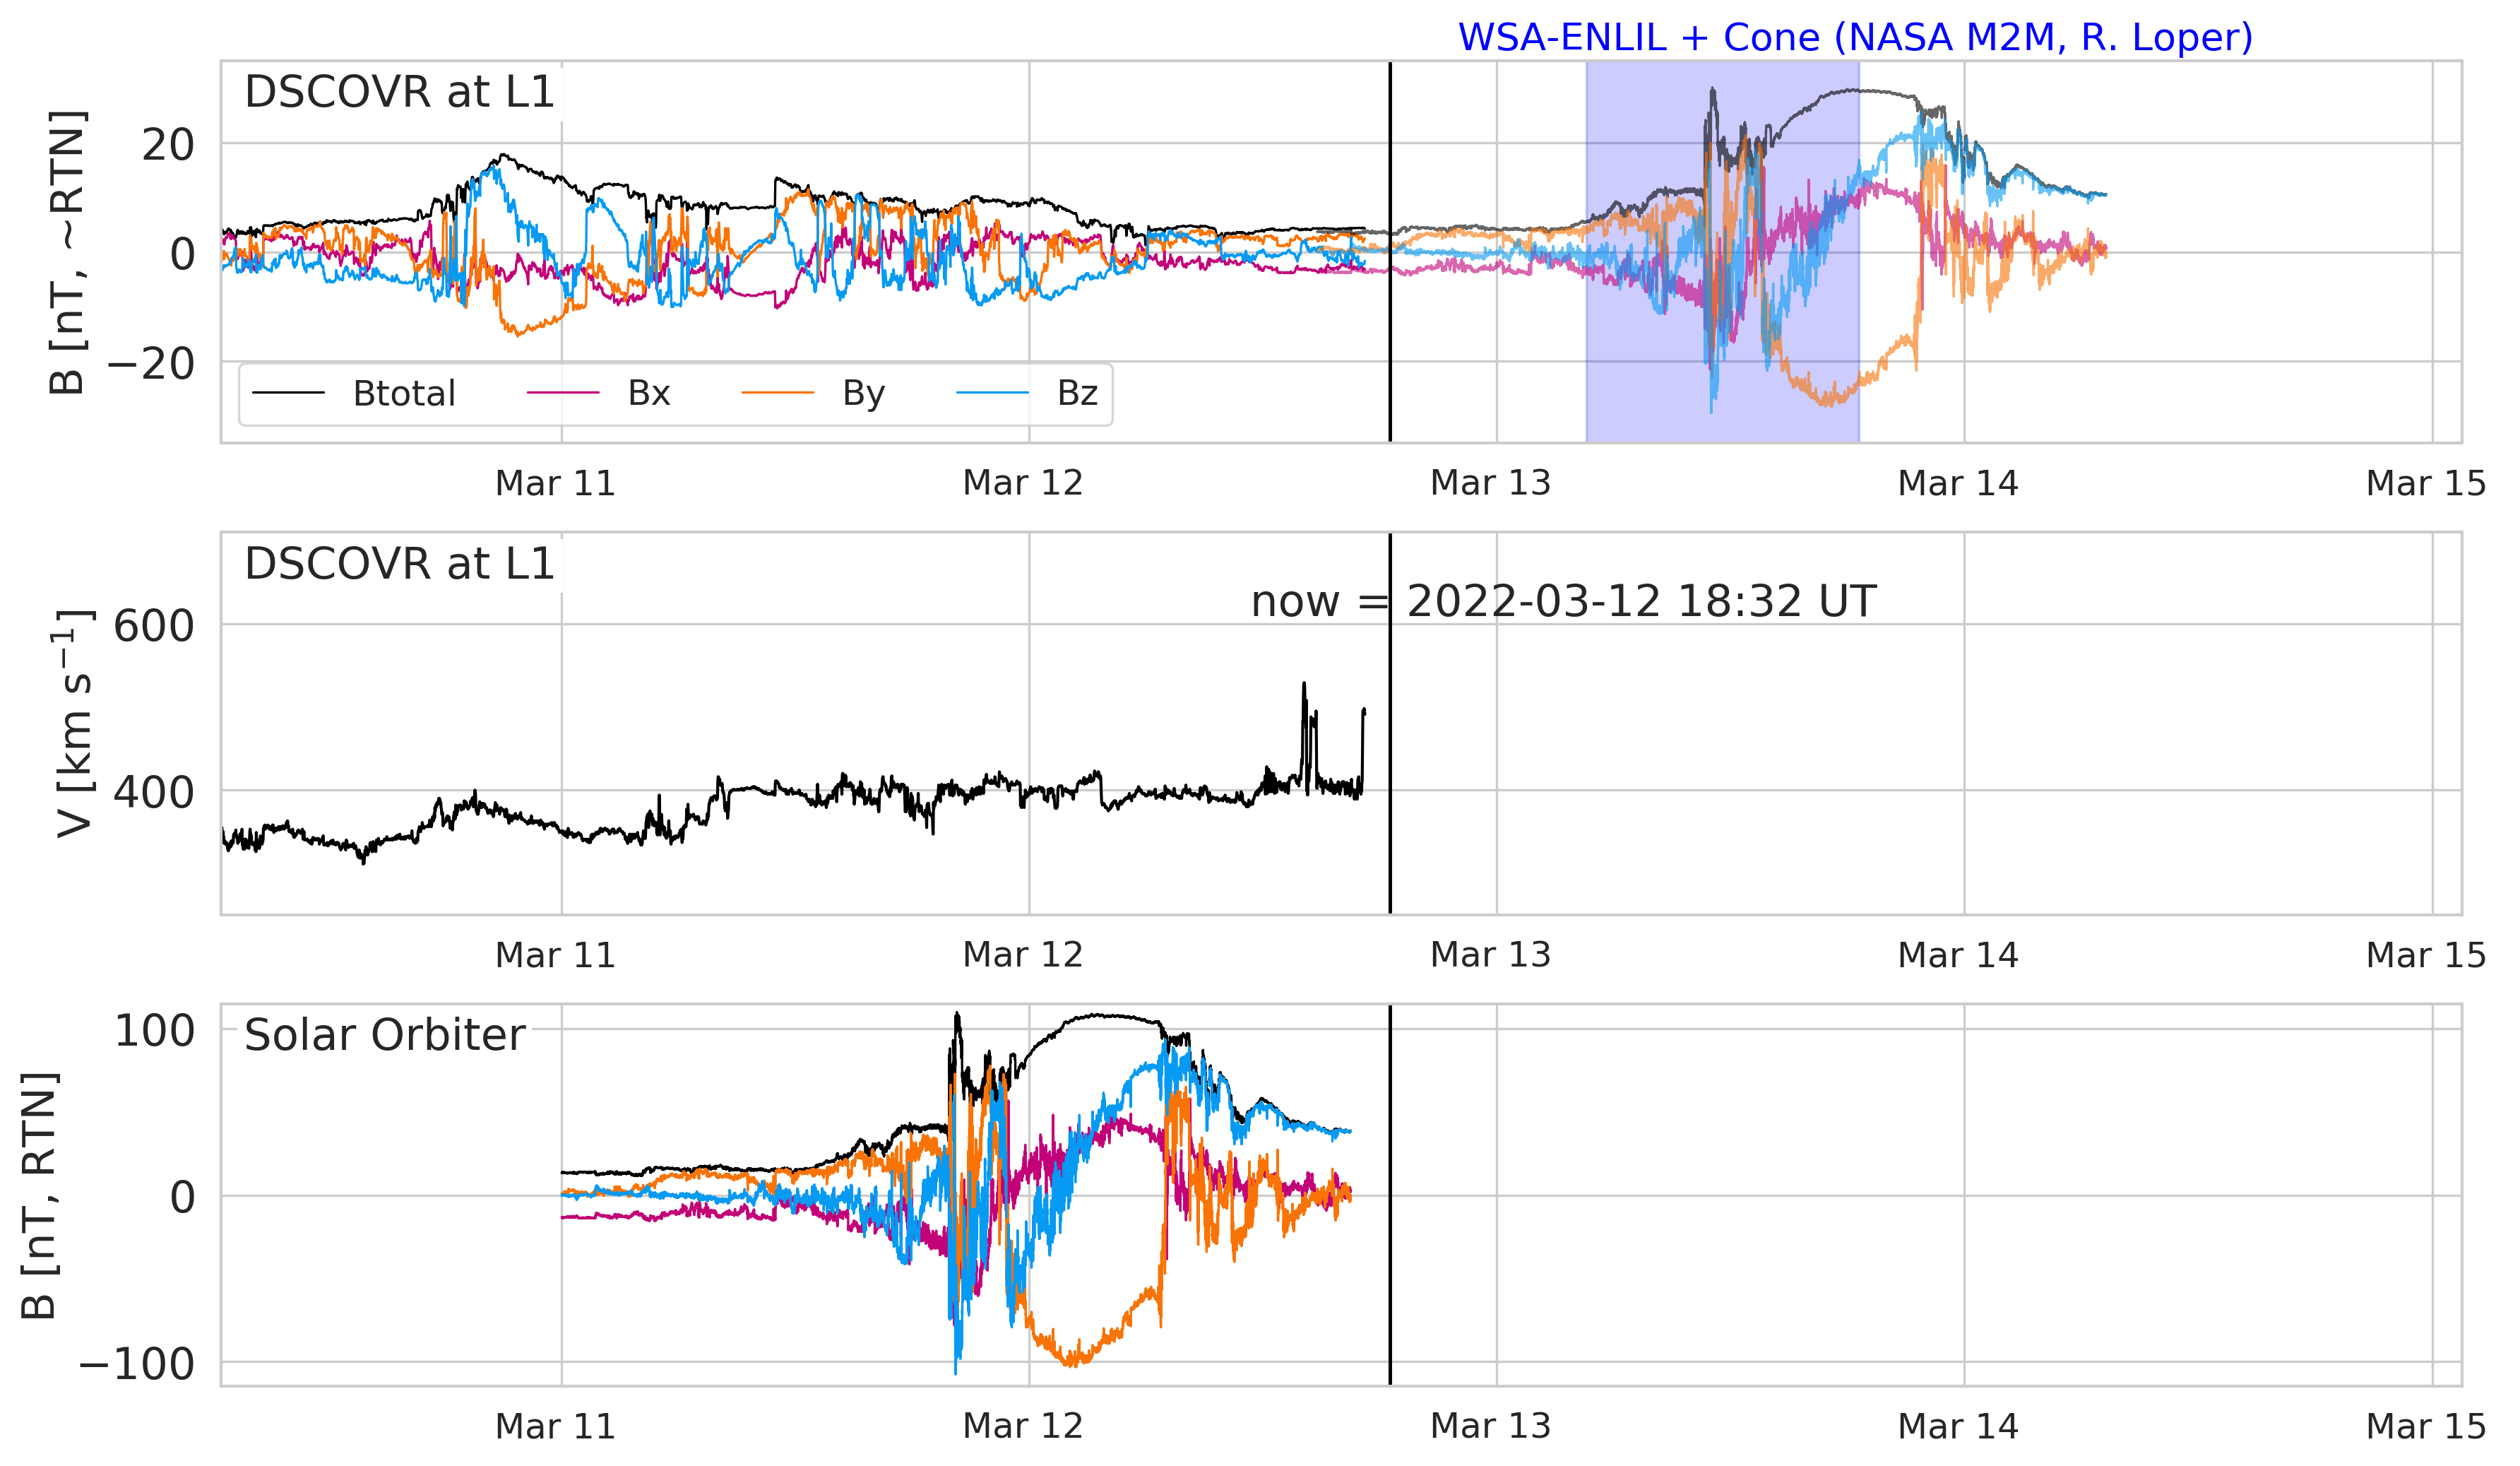

In [99]:
sns.set_style('whitegrid')
sns.set_context('paper')

plt.figure(1,figsize=(12, 7),dpi=300)

#define subplot grid
ax1 = plt.subplot2grid((3, 1), (0, 0))  
#ax2 = plt.subplot2grid((4, 1), (3, 0))  
ax3 = plt.subplot2grid((3, 1), (2, 0))  
ax11 = plt.subplot2grid((3, 1), (1, 0))  
#ax4 = plt.subplot2grid((5, 1), (4, 0))  




#plotstart=datetime.datetime(2021,10,11)
#plotend=datetime.datetime(2021,10,13,6)

#plotstart=datetime.datetime(2022,1,30)
#plotend=datetime.datetime(2022,2,5)
plotstart=datetime.datetime.utcnow()-timedelta(days=2.5)
plotend=datetime.datetime.utcnow()+timedelta(hours=55)

blim=35

linewi=0.8

days_dist=1


#NOAA real time in approx RTN
ax1.plot(noaa_real.time, noaa_real.bt, "k-", lw=linewi,label='Btotal')
ax1.plot(noaa_real.time, -noaa_real.bx, "r-", color="xkcd:magenta", lw=linewi, label='Bx')
ax1.plot(noaa_real.time, -noaa_real.by, "g-", color="xkcd:orange", lw=linewi,label='By')
ax1.plot(noaa_real.time, noaa_real.bz, "b-", color="xkcd:azure", lw=linewi,label='Bz')


#ax1.plot(win.time, win.bt, "k-", lw=linewi,label='Btotal')
#ax1.plot(win.time, win.bx, "r-", color="xkcd:magenta", lw=linewi, label='Bx')
#ax1.plot(win.time, win.by, "g-", color="xkcd:orange", lw=linewi,label='By')
#ax1.plot(win.time, win.bz, "b-", color="xkcd:azure", lw=linewi,label='Bz')

ax1.set_ylabel('B [nT, ~RTN]',fontsize=15)
ax1.set_xlim(plotstart,plotend)
ax1.set_ylim(-blim,blim)
ax1.legend(loc=3,ncol=4,fontsize=12)
ax1.grid(True)
ax1.tick_params(axis='y', labelsize=15)
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d ') )
ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))
ax1.tick_params(axis='x', labelsize=12)
#ax1.set_xticklabels([])


ax1.plot(solop.time, solop.bt, "k-", lw=linewi,label='Btotal', alpha=0.6)
ax1.plot(solop.time, solop.bx, "r-", color="xkcd:magenta", lw=linewi, label='Br',alpha=0.6)
ax1.plot(solop.time, solop.by, "g-", color="xkcd:orange", lw=linewi,label='Bt',alpha=0.6)
ax1.plot(solop.time, solop.bz, "b-", color="xkcd:azure", lw=linewi,label='Bn',alpha=0.6)


ax11.plot(noaa_real.time, noaa_real.vt, color="black",linewidth=1,label='Vp Wind')
#ax11.plot(win.time, win.vt, color="black",linewidth=1,label='Vp Wind')


ax11.set_ylabel('V [km $\mathrm{s^{-1}}$]',fontsize=15)
ax11.set_xlim(plotstart,plotend)
ax11.set_ylim(250,710)
ax11.tick_params(axis='y', labelsize=15)
ax11.grid(True)
ax11.tick_params(axis='x', labelsize=12)
ax11.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d ') )
ax11.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))

#ax11.set_xticklabels([])




### SolO Earth prediction
blim=np.nanmax(solop.bt)+5

ax2.plot(solop.time, solop.bt, "k-", lw=linewi,label='Btotal')
ax2.plot(solop.time, solop.bx, "r-", color="xkcd:magenta", lw=linewi, label='Br')
ax2.plot(solop.time, solop.by, "g-", color="xkcd:orange", lw=linewi,label='Bt')
ax2.plot(solop.time, solop.bz, "b-", color="xkcd:azure", lw=linewi,label='Bn')
    
ax2.set_ylabel('B [nT, RTN]',fontsize=15)
ax2.set_xlim(plotstart,plotend)
ax2.set_ylim(-blim,blim)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=15)
#ax2.legend(loc=1,ncol=4,fontsize=15)
ax2.grid(True)
ax2.set_xticklabels([])
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d') )
ax2.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))


### Solar Orbiter
blim=np.nanmax(solo_ll.bt)+5
#ax3.plot(solo.time, solo.bt, "k-", lw=linewi,label='Btotal')
#ax3.plot(solo.time, solo.bx, "r-", color="xkcd:magenta", lw=linewi, label='Bx')
#ax3.plot(solo.time, solo.by, "g-", color="xkcd:orange", lw=linewi,label='By')
#ax3.plot(solo.time, solo.bz, "b-", color="xkcd:azure", lw=linewi,label='Bz')

ax3.plot(solo_ll.time, solo_ll.bt, "k-", lw=linewi,label='Btotal')
ax3.plot(solo_ll.time, solo_ll.bx, "r-", color="xkcd:magenta", lw=linewi, label='Bx')
ax3.plot(solo_ll.time, solo_ll.by, "g-", color="xkcd:orange", lw=linewi,label='By')
ax3.plot(solo_ll.time, solo_ll.bz, "b-", color="xkcd:azure", lw=linewi,label='Bz')


    
ax3.set_ylabel('B [nT, RTN]',fontsize=15)
ax3.set_xlim(plotstart,plotend)
ax3.set_ylim(-blim,blim)
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', labelsize=15)
#ax2.legend(loc=1,ncol=4,fontsize=15)
ax3.grid(True)
ax3.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d ') )
ax3.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))


### Bepi
blim=80

#ax4.plot(bepi.time, bepi.bt, "k-", lw=linewi,label='Btotal')
#ax4.plot(bepi.time, bepi.bx, "r-", color="xkcd:magenta", lw=linewi, label='Br')
#ax4.plot(bepi.time, bepi.by, "g-", color="xkcd:orange", lw=linewi,label='Bt')
#ax4.plot(bepi.time, bepi.bz, "b-", color="xkcd:azure", lw=linewi,label='Bn')


######################################## longitudes


#ax4.plot(sta.time, sta.lon, linestyle="-", color="red", lw=linewi,label='STEREO-A')
#ax4.plot(solo.time, solo.lon, linestyle="-", color="orange", lw=linewi,label='SolO')
#ax4.plot(solo.time, np.zeros(len(solo.time)), "b-", color="xkcd:azure", lw=linewi,label='Earth')


#ax4.set_ylabel(' long. [deg]',fontsize=15)
#ax4.set_xlim(plotstart,plotend)
#ax4.set_ylim(-7,7)
#ax4.tick_params(axis='x', labelsize=12)
#ax4.tick_params(axis='y', labelsize=15)
#ax4.grid(True)
#ax4.legend(loc=2)
#ax4.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d ') )
#ax4.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))


ax1.annotate('DSCOVR at L1',(0.01,0.88),xycoords='axes fraction',fontsize=15,bbox=dict(facecolor='white', edgecolor='None', pad=2.0))
ax11.annotate('DSCOVR at L1',(0.01,0.88),xycoords='axes fraction',fontsize=15,bbox=dict(facecolor='white', edgecolor='None', pad=2.0))
ax2.annotate('L1 prediction based on Solar Orbiter',(0.01,0.88),xycoords='axes fraction',fontsize=15,bbox=dict(facecolor='white', edgecolor='None', pad=2.0))
ax3.annotate('Solar Orbiter',(0.01,0.88),xycoords='axes fraction',fontsize=15,bbox=dict(facecolor='white', edgecolor='None', pad=2.0))
#ax4.annotate('BepiColombo',(0.01,0.88),xycoords='axes fraction',fontsize=15,bbox=dict(facecolor='white', edgecolor='None', pad=2.0))

#ax2.annotate('Data sources: Solar Orbiter MAG (Imperial College), DSCOVR (NOAA), STEREO-A (UCLA, NASA)',(0.01,0.02),xycoords='axes fraction',fontsize=10)
#ax4.annotate('Data source: BepiColombo MPO-MAG (IGEP Braunschweig/IWF Graz/ISAS/IC)',(0.01,0.02),xycoords='axes fraction',fontsize=10)




tnow_str=str(datetime.datetime.utcnow())[0:16]

ax11.text(datetime.datetime.utcnow()-timedelta(days=0.3), 610, 'now = '+tnow_str+' UT', fontsize=15)


ax1.plot([datetime.datetime.utcnow(),datetime.datetime.utcnow()],[-500,500],'-k')
ax11.plot([datetime.datetime.utcnow(),datetime.datetime.utcnow()],[-500,5000],'-k')
ax2.plot([datetime.datetime.utcnow(),datetime.datetime.utcnow()],[-500,500],'-k')
ax3.plot([datetime.datetime.utcnow(),datetime.datetime.utcnow()],[-500,500],'-k')



#predictions
ax3.plot([datetime.datetime.utcnow(),datetime.datetime.utcnow()],[-500,500],'-k')



#https://kauai.ccmc.gsfc.nasa.gov/CMEscoreboard/prediction/detail/1617
#2022-03-13T11:35Z (plus minus 7 hours)

hi_l1_constr_start=parse_time('2022-Mar-13 11:35').datetime-timedelta(hours=7)
hi_l1_constr_end=parse_time('2022-Mar-13 11:35').datetime+timedelta(hours=7)
ax1.axvspan(hi_l1_constr_start,hi_l1_constr_end,color='blue', alpha=0.2)

ax1.text(parse_time('2022-Mar-12 22:00').datetime, 37, 'WSA-ENLIL + Cone (NASA M2M, R. Loper) ', color='blue', fontsize=13)
#ax1.text(parse_time('2022-Mar-11 22:00').datetime, 6.5, 'ElEvoHI (STEREO-A HI + Solar Orbiter)', color='blue', fontsize=13)
#ax1.text(parse_time('2022-Mar-11 22:00').datetime, 1, 'Amerstorfer/Bauer/RAL', color='blue', fontsize=13)


print('maximum Bt at SolO ',np.nanmax(solo_ll.bt))
print('maximum Bt at Earth predicted',np.nanmax(solop.bt))

print('minimum Bz at Earth predicted',np.nanmax(solop.bz))




plt.tight_layout()


plt.savefig('lineups/figure_2022_march8_prediction_march10_plots.png')
#plt.savefig('lineups/figure_2022_march8_prediction_march10_plots.pdf')


Save lowlat as txt

In [22]:
df = pd.DataFrame(solo[-30000:-1])

In [23]:
df.to_csv('lineups/solo_mag_2022march8_event.csv')

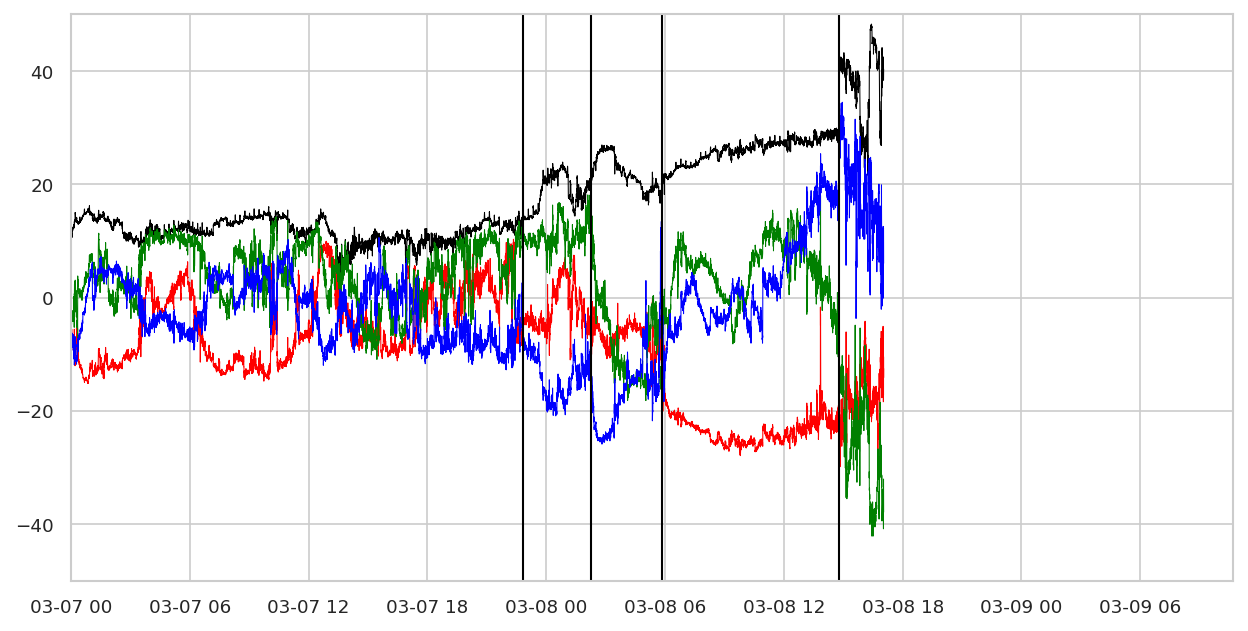

In [46]:
%matplotlib inline
plt.figure(1,figsize=(10,5),dpi=150)

#shock in the back
s4=parse_time('2022-03-08T14:47Z').datetime


#MFR mitte
s3=parse_time('2022-03-08T05:50Z').datetime

#ICME start
s2=parse_time('2022-03-08T02:15Z').datetime

#ICME start
s1=parse_time('2022-03-07T22:49Z').datetime



plt.plot(solo.time,solo.bt,color='black',lw=0.5, label='Btotal')
plt.plot(solo.time,solo.bx, color='r',lw=0.5,label='Br')
plt.plot(solo.time,solo.by,color='g',lw=0.5,label='Bt')
plt.plot(solo.time,solo.bz,color='b',lw=0.5,label='Bn')
plotstart=datetime.datetime(2022,3,7,0)
plotstart=datetime.datetime(2022,3,7,0)
plt.xlim(plotstart,plotend)
plt.ylim(-50,50)

plt.plot_date([s1,s1],[-50,50],linestyle='-',linewidth=1,color='black',marker='')  
plt.plot_date([s2,s2],[-50,50],linestyle='-',linewidth=1,color='black',marker='')  
plt.plot_date([s3,s3],[-50,50],linestyle='-',linewidth=1,color='black',marker='')  
plt.plot_date([s4,s4],[-50,50],linestyle='-',linewidth=1,color='black',marker='')  

#plt.text(datetime.datetime.utcnow()-timedelta(days=0.7), 600, tnow_str+' UT', fontsize=15)



shock is CME CME: 2022-03-07T00:12:00-CME-001

CME before is 

Please specify following CME input parameters.
Time at 21.5Rs boundary: 2022-03-05T15:02Z
Radial velocity (km/s): 224
Longitude (deg): 04N
Latitude (deg): 015E
Half-angular width (deg): 26



In [47]:
s2e=solo

In [ ]:
Please specify following CME input parameters.
Time at 21.5Rs boundary: 2022-03-07T09:20
Radial velocity (km/s): 417
Longitude (deg):  W24
Latitude (deg): N10
Half-angular width (deg): 27


In [ ]:
import pickle
import copy
import matplotlib.pyplot as plt
from matplotlib.dates import num2date, date2num
from math import pi
import sys
import py3dcore
sys.path.insert(0, "/Users/rbailey/Code/PREDSTORM")
import predstorm as ps
import heliosat
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from predstorm import dst_loss_function
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("ticks")

HI_CME_speed = 339.

# READ DATA
filemag='solo_2020_icme_april_gse.p'#'solo_april2020_gse.p'
sm=pickle.load(open(filemag, "rb" ) )
filewin='wind_2018_now_gse.p'
[win,hwin]=pickle.load(open(filewin, "rb" ) )

wind_dict, solo_dict = {}, {}
for var in ['bx', 'by', 'bz', 'bt', 'np', 'vt']:
    wind_dict[var] = win[var]
    solo_dict[var] = sm[var]
wind_dict['time'] = [date2num(x) for x in win['time']]
solo_dict['time'] = [date2num(x) for x in sm['time']]

for var, var_replace in zip(['np', 'vt', 'bt'], ['density', 'speed', 'btot']):
    wind_dict[var_replace] = win[var]
    solo_dict[var_replace] = sm[var]
    wind_dict.__delitem__(var)
    solo_dict.__delitem__(var)

Wind = ps.SatData(wind_dict)
SolO = ps.SatData(solo_dict)
Wind = Wind.cut(starttime=num2date(SolO['time'][0]), endtime=num2date(SolO['time'][-1]))

SolO.h['HeliosatObject'] = heliosat.DSCOVR()
SolO = SolO.interp_nans()
SolO.load_positions()
SolO.pos['r'] = sm['r']
SolO.pos['lat'] = sm['lat']*pi/180.
SolO.pos['lon'] = sm['lon']*pi/180.

SolO_shifted = copy.deepcopy(SolO)
# Assume speed of the expanding CME (taken from the shock front):
SolO_shifted['speed'].fill(HI_CME_speed)
# Expand wind out TO L1
SolO_shifted.shift_time_to_L1(ignore_rotation=True)
SolO_shifted.shift_wind_to_L1()
# GSE to GSM
SolO_shifted.convert_GSE_to_GSM()
SolO_shifted = SolO_shifted.interp_to_time(Wind['time'])
SolO_shifted['speed'].fill(HI_CME_speed)
SolO_shifted['density'].fill(5.)
Wind.convert_GSE_to_GSM()

# PLOT
lw = 1
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, sharex=True, figsize=(10,9))
ax0.plot_date(SolO['time'], SolO['bx'], 'r-', lw=lw, label='Bx')
ax0.plot_date(SolO['time'], SolO['by'], 'b-', lw=lw, label='By')
ax0.plot_date(SolO['time'], SolO['bz'], 'g-', lw=lw, label='Bz')
ax0.plot_date(SolO['time'], SolO['btot'], 'k-', lw=lw, label='Btot')
ax1.plot_date(SolO_shifted['time'], SolO_shifted['bx'], 'r-', lw=lw, label='Bx')
ax1.plot_date(SolO_shifted['time'], SolO_shifted['by'], 'b-', lw=lw, label='By')
ax1.plot_date(SolO_shifted['time'], SolO_shifted['bz'], 'g-', lw=lw, label='Bz')
ax1.plot_date(SolO_shifted['time'], SolO_shifted['btot'], 'k-', lw=lw, label='Btot')
ax2.plot_date(Wind['time'], Wind['bx'], 'r-', lw=lw, label='Bx')
ax2.plot_date(Wind['time'], Wind['by'], 'b-', lw=lw, label='By')
ax2.plot_date(Wind['time'], Wind['bz'], 'g-', lw=lw, label='Bz')
ax2.plot_date(Wind['time'], Wind['btot'], 'k-', lw=lw, label='Btot')
ax3.plot_date(Wind['time'], Wind['speed'], 'k-', lw=lw, label='Speed')
ax0.set_ylabel("Magnetic\nField [nT]")
ax1.set_ylabel("Magnetic\nField [nT]")
ax2.set_ylabel("Magnetic\nField [nT]")
ax3.set_ylabel("Solar wind\nspeed [km/s]")
ax3.set_xlabel("Time [UTC]")
ax0.legend(loc='upper left')
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax3.set_xlim([datetime(2020,4,18,2,30), num2date(SolO_shifted['time'][-1])])
myformat = mdates.DateFormatter("%b %d\n%H:%M")
ax3.xaxis.set_major_formatter(myformat)
plt.subplots_adjust(hspace=0.19)
ax0.set_title("Solar Orbiter magnetic field data (GSE) as measured")
ax1.set_title("Solar Orbiter magnetic field data (GSM) mapped to L1 distance")
ax2.set_title("WIND magnetic field data (GSM) at L1")
ax3.set_title("WIND plasma data at L1")
plt.savefig("solo_wind_mapped.pdf", bbox_inches='tight')
#plt.show()

SolO_shifted_h = SolO_shifted.make_hourly_data()
Wind_h = Wind.make_hourly_data()
ind_no_vals = np.where(np.abs(np.diff(SolO_shifted_h['bz'])) > 0.)[0][0]
for variable in SolO_shifted_h.vars:
    SolO_shifted_h[variable][:ind_no_vals] = Wind_h[variable][:ind_no_vals] # TODO the data should be real SolO data

# Calculate Dst:
with open('/Users/rbailey/Code/PREDSTORM/dst_pred_model_noOffset.pickle', 'rb') as f:
    model = pickle.load(f)
dst_pred = SolO_shifted_h.make_dst_prediction_from_model(model, reduced_features=False)
dst_tl = SolO_shifted_h.make_dst_prediction(method='temerin_li_2006', t_correction=True)
Dst_SOLO = dst_tl['dst'] + dst_pred['dst'] - 7

dst_pred = Wind_h.make_dst_prediction_from_model(model, reduced_features=False)   
dst_tl = Wind_h.make_dst_prediction(method='temerin_li_2006', t_correction=True)
Dst_WIND = dst_tl['dst'] + dst_pred['dst'] - 7

# Read past Dst:
Dst_OBS = ps.get_past_dst(filepath="/Users/rbailey/Code/PREDSTORM/dstarchive/WWW_dstae00010670.dat",
                          starttime=num2date(SolO_shifted['time'][0])-timedelta(hours=12), 
                          endtime=num2date(SolO_shifted['time'][-1])+timedelta(hours=12))
Dst_OBS = Dst_OBS.cut(starttime=num2date(Wind_h['time'][0]), endtime=num2date(Wind_h['time'][-1])+timedelta(hours=1))

fig = plt.figure(figsize=(10,5))
plt.plot_date(SolO_shifted_h['time']+1./24., Dst_SOLO, '--', c='teal', lw=lw, label='Predicted Dst (SolO)')
plt.plot_date(SolO_shifted_h['time']+1./24., Dst_WIND, 'b-', lw=lw, label='Predicted Dst (Wind)')
plt.plot_date(Dst_OBS['time'], Dst_OBS['dst'], 'k-', lw=2, label='Observed Kyoto Dst')
plt.legend(loc='lower left')
plt.xlim([datetime(2020,4,18,2,30), num2date(SolO_shifted['time'][-1])])
plt.ylabel("Dst [nT]")
plt.xlabel("Time [UTC]")
plt.title("Dst observed and predicted by solar wind variations")
ax = plt.gca()
myformat = mdates.DateFormatter("%b %d\n%H:%M")
ax.xaxis.set_major_formatter(myformat)
plt.savefig("dst_comparison.pdf", bbox_inches='tight')
#plt.show()

# Read 3DCORE data:
#file='april_2020_3dcore_fit_solo_forecast_earth.p'    
#[t1,btot1,bxyz1,t2,btot2,bxyz2,model_obj]=pickle.load(open(file, "rb"))
data = pd.read_csv("3DCORE_TEXTFORMAT.txt", header=None, delimiter=' ', names=['time', 'bx', 'by', 'bz', 
	'bx_max', 'by_max', 'bz_max', 'bx_min', 'by_min', 'bz_min'], dtype={'bx': 'float', 'by': 'float', 'bz': 'float'})

model_dict = {}                                                                                                                  
#model_dict['time'] = np.array([date2num(x) for x in t2])
#model_dict['btot'] = btot2
#model_dict['bx'] = bxyz2[:,0]
#model_dict['by'] = bxyz2[:,1]
#model_dict['bz'] = bxyz2[:,2]
model_dict['time'] = np.array([date2num(datetime.strptime(x, "%Y-%m-%dT%H:%M:%S%z")) for x in data['time']])
model_dict['bx'] = -data['bx']
model_dict['by'] = -data['by']
model_dict['bz'] = data['bz']
model_dict['btot'] = np.sqrt(data['bx']**2 + data['by']**2 + data['bz']**3)
model_dict['speed'] = np.full(len(data), HI_CME_speed)

Model3DCORE = ps.SatData(model_dict)

Model3DCORE.h['HeliosatObject'] = heliosat.DSCOVR()
Model3DCORE.load_positions()
r_SolO = np.interp(model_dict['time'], solo_dict['time'], sm['r'])
lat_SolO = np.interp(model_dict['time'], solo_dict['time'], sm['lat']*pi/180.)
lon_SolO = np.interp(model_dict['time'], solo_dict['time'], sm['lon']*pi/180.)
Model3DCORE.pos['r'] = r_SolO
Model3DCORE.pos['lat'] = lat_SolO
Model3DCORE.pos['lon'] = lon_SolO

Model3DCORE.shift_time_to_L1(ignore_rotation=True)
Model3DCORE.shift_wind_to_L1()
# GSE to GSM
Model3DCORE.convert_GSE_to_GSM()

Model3DCORE_h = Model3DCORE.interp_to_time(Wind_h['time'])

SolO_model = copy.deepcopy(SolO_shifted_h)
model_inds = np.where(~np.isnan(Model3DCORE_h['bx']))

for var in ['bx', 'by', 'bz', 'btot']:
    SolO_model[var][model_inds] = Model3DCORE_h[var][model_inds]

dst_pred = SolO_model.make_dst_prediction_from_model(model, reduced_features=False)   
dst_tl = SolO_model.make_dst_prediction(method='temerin_li_2006', t_correction=True)
Dst_3DCORE = dst_tl['dst'] + dst_pred['dst'] - 7

model_inds_plus1 = np.hstack((np.array([model_inds[0][0]-1]), model_inds[0]))#, np.array([model_inds[0][-1]+1])))

fig = plt.figure(figsize=(7.4,3.7))
plt.plot_date(SolO_shifted_h['time']+1./24., Dst_SOLO, '--', c='teal', lw=1.2, label='Predicted $Dst$ (SolO)')
plt.plot_date(SolO_shifted_h['time'][model_inds_plus1]+1./24., Dst_3DCORE[model_inds_plus1], 'r:', lw=1.2, label='Predicted $Dst$ (SolO+3DCORE)')
plt.plot_date(SolO_shifted_h['time']+1./24., Dst_WIND, 'b-', lw=1.2, label='Predicted $Dst$ (Wind)')
plt.plot_date(Dst_OBS['time'], Dst_OBS['dst'], 'k-', lw=2, label='Observed Kyoto $Dst$')
plt.legend(loc='lower right', fontsize=10)
#plt.xlim([datetime(2020,4,18,2,30), num2date(SolO_shifted['time'][-1])])
plt.xlim([datetime(2020,4,19,12), num2date(SolO_shifted['time'][-1])])
plt.ylim([-85,37])
plt.ylabel("$Dst$ [nT]")
plt.xlabel("Time [UTC]")
plt.title("$Dst$ observed and predicted by solar wind variations")
ax = plt.gca()
myformat = mdates.DateFormatter("%b %d\n%H:%M")
ax.xaxis.set_major_formatter(myformat)
plt.savefig("dst_comparison2.pdf", bbox_inches='tight')
#plt.show()

datestrs = [num2date(x+1./24.) for x in Wind_h['time']]
Dst_all = np.vstack((datestrs, Dst_SOLO, Dst_WIND, Dst_3DCORE, Dst_OBS['dst']))
fmt = ['%.16s', '%.2f', '%.2f', '%.2f', '%.2f']
np.savetxt('dst_prediction.txt', Dst_all.T, fmt=fmt, delimiter='\t',
           header="Date Time     \tDst_SO\tDst_WIN\tDst_3DCORE\tDst_Kyoto")






In [ ]:
#read SWA moments

#  if os.path.exists(sta_impact_path+cdf_file):
            print(cdf_file)
            f1 = cdflib.CDF(sta_impact_path+cdf_file)
            t1=parse_time(f1.varget('Epoch'),format='cdf_epoch').datetime
            t2.extend(t1)
            bfield=f1.varget('BFIELD')
            bt[i:i+len(bfield[:,3])]=bfield[:,3]
            bx[i:i+len(bfield[:,0])]=bfield[:,0]
            by[i:i+len(bfield[:,1])]=bfield[:,1]
            bz[i:i+len(bfield[:,2])]=bfield[:,2]
            i=i+len(bfield[:,3])